In [1]:
import requests
from datetime import datetime
from bs4 import BeautifulSoup
from urlparse import urljoin
import cPickle as pickle
import re
%matplotlib inline
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 1.5*matplotlib.rcParams['savefig.dpi']
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
url_base = "https://en.wikipedia.org/wiki/"
film_urls = []
for year in range(1995, 2015):
    response = requests.get(urljoin(url_base, str(year)+"_in_film"))
    soup =  BeautifulSoup(response.text, "lxml")
    content = soup.find('div', attrs={'id': 'mw-content-text'})
    tables = content.find_all('table', attrs={'class': 'wikitable'})[-4:]
    all_urls_year = []
    for table in tables:
        titles = table.find_all('i')
        url_addons = [title.find('a')['href'] for title in titles if title.find('a')!=None]
        urls = [urljoin(url_base, url_addon) for url_addon in url_addons]
        all_urls_year += urls
    film_urls += all_urls_year
film_urls = list(set(film_urls))

pickle.dump(film_urls, open('film_urls.pickle', 'w'))

In [2]:
film_urls = pickle.load(open('film_urls.pickle', 'r'))
print len(film_urls)

3790


In [ ]:
# collect the raw data of all films, which takes about half an hour
# only remove those films whose wikipages don't have an infobox, 
# which could possibly be due to wrong url links, e.g. Holly Rollers

film_data_raw = []
for i in xrange(0, len(film_urls)):
    url = film_urls[i]
    response = requests.get(url)
    soup =  BeautifulSoup(response.text, "lxml")
    infobox = soup.find('table', attrs={'class': 'infobox vevent'})
    if infobox:
        entries = infobox.find_all('tr')
        rows = [filter(lambda text: text!='', entry.text.split('\n')) for entry in entries]
        info_dict = {row[0]: row[1:] for row in rows if len(row) > 1}
        info_dict['Title'] = rows[0][0]
        info_dict['URL'] = url
        film_data_raw.append(info_dict)

pickle.dump(film_data_raw, open('film_data_raw.pickle', 'w'))

In [3]:
film_data_raw = pickle.load(open('film_data_raw.pickle', 'r'))
print len(film_data_raw)

3784


In [ ]:
# a function that grabs the USD amount for the budget and box office entries

def get_usd(text):
    BUSD_RE = re.compile(r"\$[0-9\.]+ billion")
    MUSD_RE = re.compile(r"\$[0-9\.]+ million")
    USD_RE = re.compile(r"\$[0-9,]+")
    text = text.replace(u'\xa0', u' ')
    if len(BUSD_RE.findall(text)) != 0:
        usd = float(BUSD_RE.findall(text)[-1].replace('$','').replace('billion','').strip())*10**3  # in million dollars
    elif len(MUSD_RE.findall(text)) != 0:
        usd = float(MUSD_RE.findall(text)[-1].replace('$','').replace('million','').strip())  # in million dollars
    elif len(USD_RE.findall(text)) != 0:
        base_k = USD_RE.findall(text)[-1].replace('$','').split(',')
        usd = 0
        for i in range(len(base_k)):
            usd += int(base_k[-i-1])*10**(3*i-6)  # in million dollars
    else:
        usd = -1
    return usd

# remove those don't have budget or box office, or have anomalous budget or box office

film_data = []
for film in film_data_raw:
    if all([
        'Directed by' in film, 
        'Produced by' in film, 
        'Starring' in film, 
        'Music by' in film, 
        'Cinematography' in film, 
        'Edited by' in film, 
        'Budget' in film, 
        'Box office' in film, 
    ]):
        budget = get_usd(film['Budget'][0])
        box_office = get_usd(film['Box office'][-1])
        if budget > 0.001 and box_office > 0.001:
            film['Budget'] = budget
            film['Box office'] = box_office
            film_data.append(film)
            
pickle.dump(film_data, open('film_data.pickle', 'w'))

In [4]:
film_data = pickle.load(open('film_data.pickle', 'r'))
print len(film_data)

2692


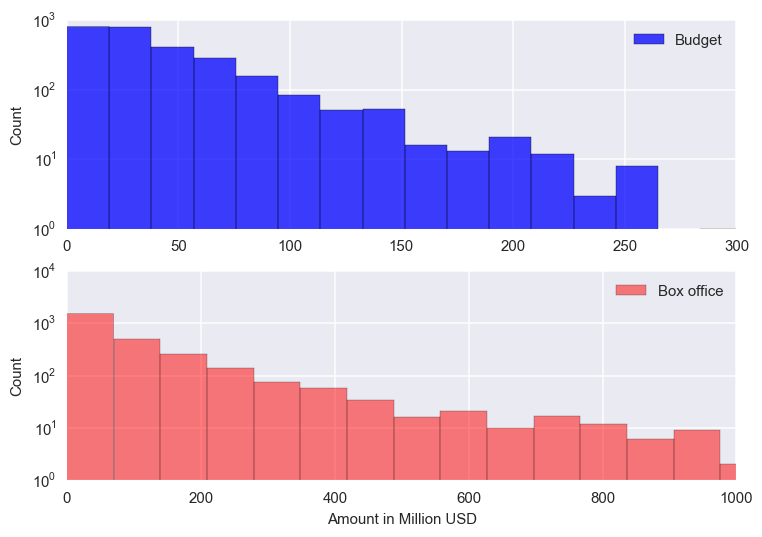

In [5]:
budgets = [film['Budget'] for film in film_data]
box_offices = [film['Box office'] for film in film_data]

plt.subplot(2, 1, 1)
plt.hist(budgets, bins=20, alpha=0.75, color='b', label='Budget')
plt.xlim(0,300)
plt.yscale('log')
plt.ylabel('Count', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc=1, fontsize=10)

plt.subplot(2, 1, 2)
plt.hist(box_offices, bins=40, alpha=0.5, color='r', label='Box office')
plt.xlim(0,1000)
plt.yscale('log')
plt.xlabel('Amount in Million USD', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc=1, fontsize=10)

plt.show()

In [6]:
bo_director = {}
for film in film_data:
    directors = film['Directed by']
    box_office = film['Box office']
    for director in directors:
        if director not in bo_director:
            bo_director[director] = [box_office]
        else:
            bo_director[director].append(box_office)
for director in bo_director:
    if len(bo_director[director]) <= 5:
        bo_director[director] = 0
    else:
        bo_director[director] = float(sum(bo_director[director]))/len(bo_director[director])

In [7]:
bo_actor = {}
for film in film_data:
    actors = film['Starring']
    box_office = film['Box office']
    for actor in actors:
        if actor not in bo_actor:
            bo_actor[actor] = [box_office]
        else:
            bo_actor[actor].append(box_office)
for actor in bo_actor:
    if len(bo_actor[actor]) <= 10:
        bo_actor[actor] = 0
    else:
        bo_actor[actor] = float(sum(bo_actor[actor]))/len(bo_actor[actor])

In [8]:
bo_musician = {}
for film in film_data:
    musicians = film['Music by']
    box_office = film['Box office']
    for musician in musicians:
        if musician not in bo_musician:
            bo_musician[musician] = [box_office]
        else:
            bo_musician[musician].append(box_office)
for musician in bo_musician:
    if len(bo_musician[musician]) <= 10:
        bo_musician[musician] = 0
    else:
        bo_musician[musician] = float(sum(bo_musician[musician]))/len(bo_musician[musician])

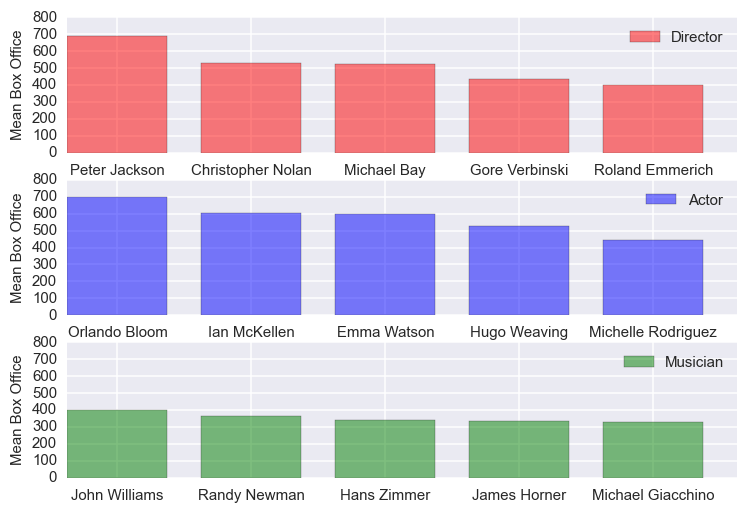

In [9]:
df_director = pd.DataFrame({'Box office': bo_director.values()}, index=bo_director.keys())
df_actor = pd.DataFrame({'Box office': bo_actor.values()}, index=bo_actor.keys())
df_musician = pd.DataFrame({'Box office': bo_musician.values()}, index=bo_musician.keys())
top_director = df_director.sort('Box office', ascending=False)
top_actor = df_actor.sort('Box office', ascending=False)
top_musician = df_musician.sort('Box office', ascending=False)

n_people = 5
index = np.arange(n_people)
bar_width = 0.75

plt.subplot(3, 1, 1)
plt.bar(index, top_director.values[:n_people], bar_width, color='r', alpha=0.5, label='Director')
plt.ylim(0,800)
plt.ylabel('Mean Box Office', fontsize=10)
plt.xticks(index+bar_width/2, top_director.index[:n_people], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc=1, fontsize=10)

plt.subplot(3, 1, 2)
plt.bar(index, top_actor.values[:n_people], bar_width, color='b', alpha=0.5, label='Actor')
plt.ylim(0,800)
plt.ylabel('Mean Box Office', fontsize=10)
plt.xticks(index+bar_width/2, top_actor.index[:n_people], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc=1, fontsize=10)

plt.subplot(3, 1, 3)
plt.bar(index, top_musician.values[:n_people], bar_width, color='g', alpha=0.5, label='Musician')
plt.ylim(0,800)
plt.ylabel('Mean Box Office', fontsize=10)
plt.xticks(index+bar_width/2, top_musician.index[:n_people], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc=1, fontsize=10)

plt.show()

In [ ]:
for film in film_data:
    if 'Peter Jackson' in film['Directed by']:
        print film['URL']

In [ ]:
for film in film_data:
    if 'Rupert Grint' in film['Starring']:
        print film['URL']

In [ ]:
for film in film_data:
    if 'Brad Fiedel (themes)' in film['Music by']:
        print film['URL']

In [ ]:
bo_actor['Tom Cruise']